In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Download the Dataset for Inference

In [ ]:
# install kaggle
!pip install -q kaggle

In [ ]:
# create kaggle folder
!mkdir ~/.kaggle

# copy the kaggle.json to the folder created
!cp /content/drive/MyDrive/Colab_Notebooks/Kaggle_API_Token/kaggle.json ~/.kaggle/

# permission for the jason to act
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Loading the dataset using Kaggle API Command
!kaggle datasets download -d humansintheloop/semantic-segmentation-of-aerial-imagery

 84% 25.0M/29.6M [00:00<00:00, 41.9MB/s]
100% 29.6M/29.6M [00:00<00:00, 53.5MB/s]


In [ ]:
# Unzipping the dataset
!unzip /content/semantic-segmentation-of-aerial-imagery.zip

# Inferencing in Two Ways:
Divide image in smaller patches - predict mask for each patch - Combine them up
- without smooth blending
- with smooth blending

#### Download `smooth_tiled_predictions.py` for smoothly blending the masks

In [ ]:
!wget https://raw.githubusercontent.com/Suvam-Bit/Arial-Imagery-Semantic-Segmentation/main/smooth_tiled_predictions.py

--2022-06-25 20:26:25--  https://raw.githubusercontent.com/Suvam-Bit/Arial-Imagery-Semantic-Segmentation/main/smooth_tiled_predictions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10237 (10.0K) [text/plain]
Saving to: ‘smooth_tiled_predictions.py’

smooth_tiled_predic 100%[===================>]  10.00K  --.-KB/s    in 0s      

2022-06-25 20:26:25 (110 MB/s) - ‘smooth_tiled_predictions.py’ saved [10237/10237]



#### Install `patchify` library to divide an image into smaller patches

In [6]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import os
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
from patchify import patchify, unpatchify
import tensorflow as tf
from tensorflow import keras

#### Load The Custom Trained Model

In [2]:
model_path = '/content/drive/MyDrive/Colab_Notebooks/Object_Segmentation/U_Net/Unet_Arial_Imagery/arial_imagery_model.h5'
PATCH_SIZE = 256

model = keras.models.load_model(model_path, compile = False)

#### Reading the paths of the images and their masks

In [3]:
DATA_SOURCE_PATH = '/content/Semantic segmentation dataset'
tiles = sorted(os.listdir(DATA_SOURCE_PATH))[:-1]

images_paths = []
for tile in tiles:
    fil_pre_path = os.path.join(DATA_SOURCE_PATH, tile, 'images')
    for fil in sorted(os.listdir(fil_pre_path)):
        fil_path = os.path.join(fil_pre_path, fil)
        images_paths.append(fil_path)

masks_paths = []
for tile in tiles:
    fil_pre_path = os.path.join(DATA_SOURCE_PATH, tile, 'masks')
    for fil in sorted(os.listdir(fil_pre_path)):
        fil_path = os.path.join(fil_pre_path, fil)
        masks_paths.append(fil_path)

#### Display a sample image and its actual mask

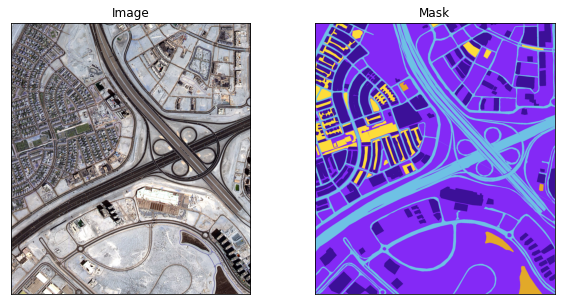

In [ ]:
sample_id = np.random.randint(0, len(images_paths), size = 1)[0]
img = cv2.cvtColor(cv2.imread(images_paths[sample_id]), cv2.COLOR_BGR2RGB)
mask = cv2.cvtColor(cv2.imread(masks_paths[sample_id]), cv2.COLOR_BGR2RGB)

plt.figure(figsize = (10,5))

plt.subplot(121)
plt.imshow(img)
plt.title('Image')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(mask)
plt.title('Mask')
plt.xticks([])
plt.yticks([])

plt.show()

#### Convert the hex color codes to RGB color codes

In [4]:
hex_color_codes = {'Building': '#3C1098',
                    'Land': '#8429F6',
                    'Road': '#6EC1E4',
                    'Vegetation': '#FEDD3A',
                    'Water': '#E2A929',
                    'Unlabeled': '#9B9B9B'}

In [5]:
rgb_colors = [tuple(int(hex[1:][i:i+2], 16) for i in (0, 2, 4)) for hex in hex_color_codes.values()]
rgb_colors

[(60, 16, 152),
 (132, 41, 246),
 (110, 193, 228),
 (254, 221, 58),
 (226, 169, 41),
 (155, 155, 155)]

In [6]:
rgb_color_codes = {label: color for label, color in zip(list(hex_color_codes.keys()), rgb_colors)}
rgb_color_codes

{'Building': (60, 16, 152),
 'Land': (132, 41, 246),
 'Road': (110, 193, 228),
 'Unlabeled': (155, 155, 155),
 'Vegetation': (254, 221, 58),
 'Water': (226, 169, 41)}

In [7]:
category_codes = {'Building': 0,
                    'Land': 1,
                    'Road': 2,
                    'Unlabeled': 3,
                    'Vegetation': 4,
                    'Water': 5}

category_codes_reversed = {i: label for label, i in category_codes.items()}

category_codes_reversed

{0: 'Building',
 1: 'Land',
 2: 'Road',
 3: 'Unlabeled',
 4: 'Vegetation',
 5: 'Water'}

#### Function to convert integer labeled mask to RGB mask

In [8]:
def int_color_label_to_RGB(labeled_mask):
    mask = np.zeros(labeled_mask.shape + (3,), dtype = np.uint8)
    
    for key in category_codes_reversed.keys():
        mask[labeled_mask == key] = rgb_color_codes[category_codes_reversed[key]]

    return mask

#### Function to predict the mask without smooth blending

In [9]:
def predict_mask_without_smoothing(img_rgb, patch_size, model):
    cropped_height = int((img_rgb.shape[0]//patch_size)*patch_size)
    cropped_width = int((img_rgb.shape[1]//patch_size)*patch_size)
    cropped_image = img_rgb[:cropped_height, :cropped_width]
    patches = patchify(cropped_image, (patch_size, patch_size, 3), step = patch_size)
    patches = np.squeeze(patches, axis = 2)

    pred_mask = []
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            patch = patches[i,j,...]
            patch = np.expand_dims(patch, axis = 0)
            patch_prediction = model.predict(patch)
            patch_prediction = np.squeeze(patch_prediction)
            patch_pred_mask = np.argmax(patch_prediction, axis = 2)
            pred_mask.append(patch_pred_mask)

    pred_mask = np.array(pred_mask)
    pred_mask = pred_mask.reshape(patches.shape[:-1])
    pred_mask = unpatchify(pred_mask, cropped_image.shape[:-1])
    pred_mask = int_color_label_to_RGB(pred_mask)

    return pred_mask

#### Function to predict the mask with smooth blending

In [10]:
from smooth_tiled_predictions import predict_img_with_smooth_windowing

def predict_mask_with_smoothing(img_rgb, patch_size, model, n_classes):
    predictions_smooth = predict_img_with_smooth_windowing(
    img_rgb,
    window_size = patch_size,
    subdivisions = 2,
    nb_classes = n_classes,
    pred_func=(lambda img_batch_subdiv: model.predict((img_batch_subdiv))))

    pred_mask = np.argmax(predictions_smooth, axis=2)
    pred_mask = int_color_label_to_RGB(pred_mask)

    return pred_mask

# Prediction of mask for an image in both ways (Without Smoothing & With Smoothing)

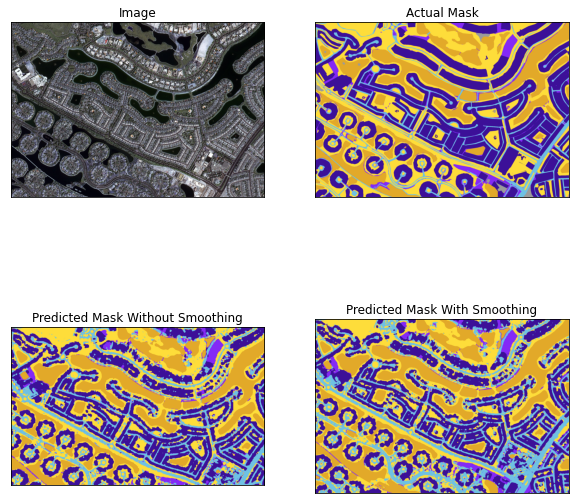

In [11]:
from IPython.display import clear_output

n_classes = 6

sample_id = np.random.randint(0, len(images_paths), size = 1)[0]

sample_image = cv2.cvtColor(cv2.imread(images_paths[sample_id]), cv2.COLOR_BGR2RGB)
sample_mask = cv2.cvtColor(cv2.imread(masks_paths[sample_id]), cv2.COLOR_BGR2RGB)
predicted_mask_without_smoothing = predict_mask_without_smoothing(sample_image, PATCH_SIZE, model)
predicted_mask_with_smoothing = predict_mask_with_smoothing(sample_image, PATCH_SIZE, model, n_classes)
clear_output()


plt.figure(figsize = (10, 10))

plt.subplot(221)
plt.imshow(sample_image)
plt.title('Image')
plt.xticks([])
plt.yticks([])

plt.subplot(222)
plt.imshow(sample_mask)
plt.title('Actual Mask')
plt.xticks([])
plt.yticks([])

plt.subplot(223)
plt.imshow(predicted_mask_without_smoothing)
plt.title('Predicted Mask Without Smoothing')
plt.xticks([])
plt.yticks([])

plt.subplot(224)
plt.imshow(predicted_mask_with_smoothing)
plt.title('Predicted Mask With Smoothing')
plt.xticks([])
plt.yticks([])

plt.show()